# Calculate & Alfven wave instability threshold

In [1]:
import sys
sys.path.append('/Users/ygtong/research/vlasov_solver/')

In [2]:
import numpy as np
import scipy.optimize
import scipy.interpolate
from py_vlasov.util import kzkp
# from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
# from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
# from py_vlasov.transport_ratios import transport_ratios
# from py_vlasov.follow_parameter import generate_steps, solve_disp
from KSpaceSearch import KThetaScan
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import ceil
import os
import pandas as pd

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

## Base parameters

In [3]:
# aol = np.sqrt(2.65e-8)
aol = np.sqrt(1e-8)
print('aol = ', aol)
tc_tp = 2
th_tc = 6
nc_np = 0.95
nh_np = 1 - nc_np
# vc_va = 2.42
vc_va = 5
vh_va = -vc_va * nc_np / nh_np
print('vh_va = {0:.3g}'.format(vh_va))

# betap = 0.25
betap = .5
theta = 80


t_list=[1., tc_tp, th_tc * tc_tp]
a_list=[1., 1., 1.]
n_list=[1., nc_np, nh_np] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., vc_va, vh_va]
n = 6
method = 'pade'

k = 0.2

target_k = 2

kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol =  0.0001
vh_va = -95


In [4]:
def genParam(betap, vcva, param):
    newParam = param.copy()
    newParam[2] = betap
    n_list = param[5]
    vhva = - vcva * n_list[1] / n_list[2]
    newParam[8] = [0, vcva, vhva]
    return newParam

In [54]:
# Data for this iteration

betap = 1.
vcva = 6.6
new_param = genParam(betap, vcva, param)

# data storage

In [55]:
result_db_file = 'data/alfven_instability.csv'
column_list = ['betap', 'vcva', 'tctp', 'thtc', 'vac', 
               'max_growth_rate', 'kz_peak', 'kp_peak', 'theta_peak']
if os.path.exists(result_db_file):
    df = pd.read_csv(result_db_file)
else:
    df = pd.DataFrame(columns= column_list)

In [56]:
# df = df.iloc[1:]
df[df.betap == betap]

,betap,vcva,tctp,thtc,vac,max_growth_rate,kz_peak,kp_peak,theta_peak
50,1.0,5.7,2,6,0.0001,0.000449,0.202,2.64,85.6
51,1.0,5.8,2,6,0.0001,0.001570,0.204,2.73,85.7
52,1.0,6.0,2,6,0.0001,0.003850,0.205,2.82,85.8
53,1.0,6.4,2,6,0.0001,0.008600,0.207,2.98,86.0


In [57]:
alfven_stop_condition = lambda guess, wrel: (wrel.real > 1) or (wrel.real <= 0) or (wrel.imag < -.5) or (wrel.real < 0.3 * guess)
ktscan = KThetaScan(new_param, 
                    lin_incrmt=.05, 
                    incrmt_method='linear', 
                    gridNum = 500,
                    stop_condition=alfven_stop_condition, 
                    diagnostic_dir = 'alfven_instability_diagnostics/', 
                    savefig = True)

No user provided wave mode guess function. Use default Alfven guess.


In [58]:
theta_min = 85
theta_max = 87.5
n_theta = int(np.ceil(theta_max - theta_min)+1) * 4
theta_arr = np.linspace(theta_min, theta_max, n_theta)

In [59]:
k_min = 0.5
k_max = 3.6

kz_2d, kp_2d, k_2d, wrel_2d = ktscan.fullScan(theta_arr, k_min, k_max)

betap=1_vcva=6.6_tctp=2_thtc=6_vac=0.0001


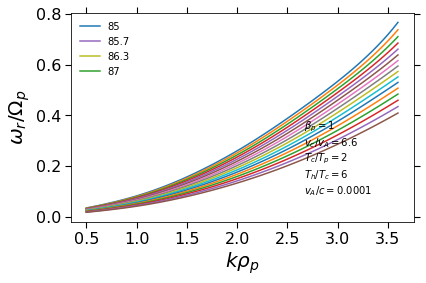

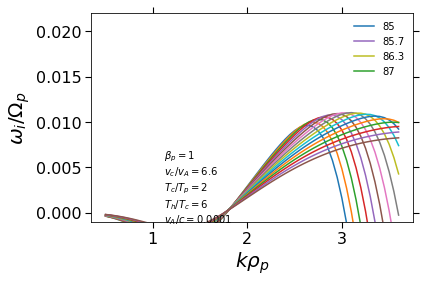

In [60]:
ktscan.makeDiagnostics1D(theta_arr, k_2d, wrel_2d)

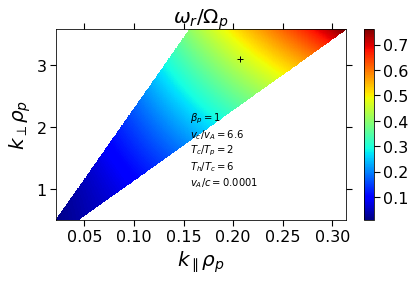

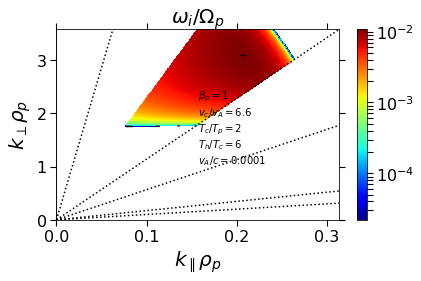

In [61]:
ktscan.makeDiagnostics2D(theta_arr, kz_2d, kp_2d, wrel_2d)

In [62]:
# save data to file

data_dict = {'betap': betap, 'vcva': vcva, 'tctp': tc_tp, 'thtc': th_tc, 'vac': aol, 
             'max_growth_rate': ktscan.maxGrowthRate, 
             'kz_peak': ktscan.maxGrowthK[0], 
             'kp_peak': ktscan.maxGrowthK[1], 
             'theta_peak': ktscan.maxGrowthTheta}
new_row = pd.DataFrame(data=data_dict, columns=column_list, index=[0])
df = df.append(new_row)

In [63]:
ktscan.maxGrowthRate

0.011027663181754962

In [64]:
# df = df.iloc[:-1]
df = df.sort_values(['betap', 'vcva'], ascending=[True, True])
df[df.betap == betap]

,betap,vcva,tctp,thtc,vac,max_growth_rate,kz_peak,kp_peak,theta_peak
50,1.0,5.7,2,6,0.0001,0.000449,0.202000,2.640000,85.600000
51,1.0,5.8,2,6,0.0001,0.001570,0.204000,2.730000,85.700000
52,1.0,6.0,2,6,0.0001,0.003850,0.205000,2.820000,85.800000
53,1.0,6.4,2,6,0.0001,0.008600,0.207000,2.980000,86.000000
0,1.0,6.6,2,6,0.0001,0.011028,0.206985,3.096719,86.176032


In [65]:
df.to_csv(result_db_file, float_format='%.3g', index=False)

In [66]:
# !ls alfven_instability_diagnostics

In [67]:
!du -sh data/alfven_instability.csv

4.0K	data/alfven_instability.csv


In [68]:
result_db_file

'data/alfven_instability.csv'

In [36]:
!pwd

/Users/ygtong/research/vlasov_solver/tests
